In [2]:
import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 4


In [3]:
def convert(tree, training_vars):
    array = tree.arrays()    
    df = pd.DataFrame(array, columns=training_vars)

    #feature = tree2array(tree,
    #                    branches = ['dRmm','dEtamm','dPhimm','M_jj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
    #                               ,'dRmin_mmj','dRmax_mmj','dPhijj','leadingJet_pt','subleadingJet_pt',
    #                               'leadingJet_eta','subleadingJet_eta','cthetaCS','Higgs_mass','Higgs_pt','Higgs_eta' ],
    #                    selection = 'dRmm>-9000.')

    return df

In [6]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt', b'subleading_bjet_eta', b'subleading_bjet_phi']

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

SIGNAL_FILE='/bigdata/shared/idutta/VBFHToMuMu.root'
BKG_FILE='/bigdata/shared/idutta/DYJetsToLL.root'

path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'
paths = ["job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root", 
         "job_2_ntuple0625v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8.root", 
         "job_3_ntuple0625v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8.root", 
         "job_4_ntuple0625v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8.root", 
         "job_5_ntuple0625v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8.root", 
         "job_6_ntuple0625v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root", 
         "job_7_ntuple0625v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root", 
         "job_8_ntuple0625v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-Sherpa.root", 
         "job_9_ntuple0625v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-Sherpa.root", 
         "job_10_ntuple0625v1/DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root"]
names = ['GluGluToHH signal', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox' ]

BKG_files = []
BKG_trees = []
BKG_frames_all = []
BKG_frames = []
BKG_dfs = []
BKG_weights = []
for i in range(len(paths)):
    BKG_FILE = uproot.open(path+paths[i])
    bkg_tree = BKG_FILE['tree']
    bkg_frame_all = convert(bkg_tree, training_vars + aug_vars + w_var)
    bkg_frame = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars]
    bkg_df = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars + w_var]
    bkg_weight = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][w_var]
    BKG_files.append(BKG_FILE)
    BKG_trees.append(bkg_tree)
    BKG_frames_all.append(bkg_frame_all)
    BKG_frames.append(bkg_frame)
    BKG_dfs.append(bkg_df)
    BKG_weights.append(bkg_weight)
    

SIGNAL_FILE = uproot.open(path + 'job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root')
    
sigtree = SIGNAL_FILE['tree']

sig_frame_all = convert(sigtree, training_vars + aug_vars + w_var)

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars]

sig_df = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars + w_var]

sig_weight = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [39]:
sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',b'subleading_bjet_eta',b'subleading_bjet_phi',b'genweight'
1,145.241119,0.918335,0.491089,75.707062,0.319824,1.547607,142.2500,2.209473,-2.042480,28.140625,0.004900,-0.789917,0.000139
5,81.548317,-0.114059,2.528809,68.587204,-0.079712,0.564209,80.1250,-1.288086,-0.381775,60.750000,-1.138916,-2.197266,-0.000139
7,109.037231,-0.835327,1.176514,87.997322,-0.765747,2.546875,115.9375,-1.357910,-1.699951,69.312500,-0.727295,-0.625854,0.000139
9,99.698898,-0.390930,-0.474426,54.716755,-0.526611,1.511963,92.5625,0.323792,2.379883,26.750000,2.041504,-3.094238,0.000139
10,78.673645,2.106934,-1.360596,74.914726,1.376465,0.152924,178.5000,1.395996,2.549316,31.062500,1.725098,0.694458,0.000139


In [40]:
sig_weight.head()

,b'genweight'
1,0.000139
5,-0.000139
7,0.000139
9,0.000139
10,0.000139


In [7]:
#bkg_frame.head()
# Standardize

frames = [BKG_frames[6], BKG_frames[7], BKG_frames[8]]
bkg_frame_com = pd.concat(frames)

x_mean = bkg_frame_com.mean()
x_std = bkg_frame_com.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame_com = (bkg_frame_com-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame_com.values
#print signal, background

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
#from skopt import gp_minimize

In [8]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]

TRAIN: [     1      2      3 ... 104911 104912 104913] TEST: [     0      4      8 ... 104905 104906 104907]
TRAIN: [     0      1      2 ... 104911 104912 104913] TEST: [     6     10     14 ... 104899 104904 104909]
TRAIN: [     0      1      2 ... 104909 104910 104913] TEST: [     9     13     17 ... 104908 104911 104912]
TRAIN: [     0      2      4 ... 104911 104912 104913] TEST: [     1      3      7 ... 104892 104896 104901]
TRAIN: [     0      1      3 ... 104909 104911 104912] TEST: [     2      5     19 ... 104903 104910 104913]


In [9]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(70, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

(83932, 12)
(83932,)
(20982, 12)
(20982,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                7070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense

2021-07-22 14:09:54.398717: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-07-22 14:09:54.478411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-07-22 14:09:54.478456: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-07-22 14:09:54.746025: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-07-22 14:09:54.933995: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-07-22 14:09:55.365709: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuran

In [10]:
print(x_train)
print(y_train)

[[ 1.9086349   0.58295023  1.1390473  ...  0.04111709  1.3121215
  -0.22042249]
 [ 0.20359057 -0.32116145 -1.6027476  ...  1.8034571   0.33855465
  -0.8446613 ]
 [ 1.3584061   1.3072362  -1.5744622  ...  1.9254048   1.5708845
  -0.10388939]
 ...
 [ 0.7507019  -0.03275008 -0.21982883 ...  2.0040808  -1.2762735
   1.6905655 ]
 [ 0.73772454  1.3122189   0.7830558  ...  1.8781993   1.5343285
  -0.5892924 ]
 [ 0.06193104  1.8814431   0.36591393 ... -0.21654648 -1.3428782
  -1.4199487 ]]
[1. 1. 1. ... 0. 0. 0.]


In [11]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [12]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
448/448 [==============================] - 1s 3ms/step - loss: 0.5353 - accuracy: 0.7311 - val_loss: 0.5842 - val_accuracy: 0.7261
Epoch 2/50
448/448 [==============================] - 1s 2ms/step - loss: 0.4813 - accuracy: 0.7760 - val_loss: 0.5731 - val_accuracy: 0.7434
Epoch 3/50
448/448 [==============================] - 1s 2ms/step - loss: 0.4704 - accuracy: 0.7825 - val_loss: 0.5350 - val_accuracy: 0.7537
Epoch 4/50
448/448 [==============================] - 1s 2ms/step - loss: 0.4645 - accuracy: 0.7826 - val_loss: 0.5584 - val_accuracy: 0.7382
Epoch 5/50
448/448 [==============================] - 1s 2ms/step - loss: 0.4599 - accuracy: 0.7848 - val_loss: 0.5277 - val_accuracy: 0.7621
Epoch 6/50
448/448 [==============================] - 1s 2ms/step - loss: 0.4556 - accuracy: 0.7878 - val_loss: 0.5025 - val_accuracy: 0.7633
Epoch 7/50
448/448 [==============================] - 1s 2ms/step - loss: 0.4529 - accuracy: 0.7890 - val_loss: 0.5448 - val_accuracy: 0.7405
Epoch 

2021-07-22 14:10:06.963697: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [13]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

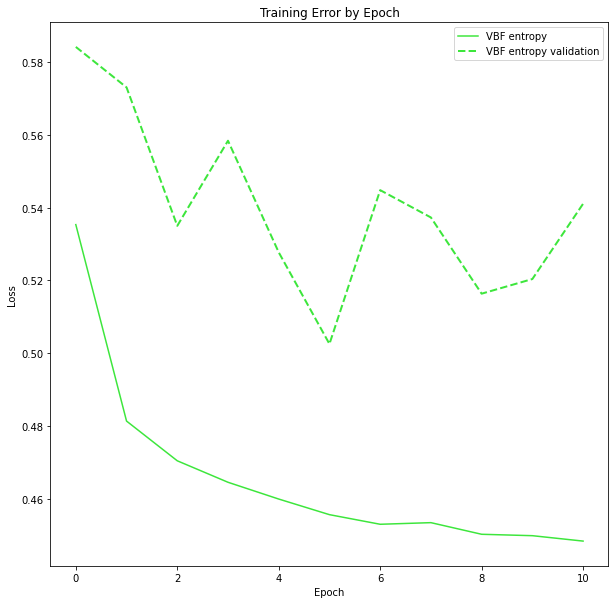

In [14]:
show_losses( [("VBF entropy", hist)])

In [17]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [18]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

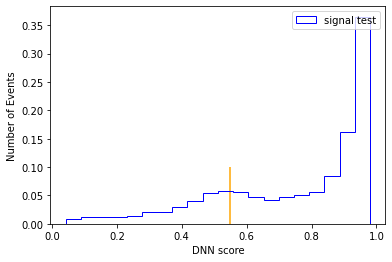

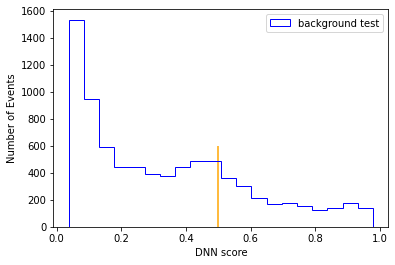

In [27]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.vlines(0.5, ymin=0, ymax = 600, color = 'orange')
plt.legend(loc = 'best')
plt.show()

In [33]:
# Bkg reduction
def significance(k):
    print(k)
    bgd = y_pred[y_test == 0]
    print(bgd)
    print(f'# background: {len(bgd)}')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}')

    sgl = y_pred[y_test == 1]
    print(sgl)
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}')
    print(f'original S/(S+B): {np.sum(sig_weight_np_sfl) / (np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}')
    print(f'original test S/(S+B): {np.sum(sgl_weight) / (np.sum(sgl_weight) + np.sum(bgd_weight))}')
    print(f'S/(S+B): {re_sig / (re_sig + re_bkg)}')
    return re_sig / (re_sig + re_bkg)

0.5
[0.13455734 0.63184804 0.2859366  ... 0.46860278 0.31097972 0.10026704]
# background: 11344
# false signal: 2872
[0.67482364 0.96596277 0.5545215  ... 0.6350313  0.97580373 0.9668121 ]
# signal: 9638
# true signal: 8087
original background: 40150.4140625
original test background: 8109.23486328125
original signal: 5.967202663421631
original test signal: 1.189465045928955
remaining background: 2039.9227058887482
remaining signal: 0.9817531658627558
original S/(S+B): 0.00014859910879749805
original test S/(S+B): 0.0001466588000766933
S/(S+B): 0.00048103827766515057
0.5236842105263158
[0.13455734 0.63184804 0.2859366  ... 0.46860278 0.31097972 0.10026704]
# background: 11344
# false signal: 2575
[0.67482364 0.96596277 0.5545215  ... 0.6350313  0.97580373 0.9668121 ]
# signal: 9638
# true signal: 7855
original background: 40150.4140625
original test background: 8109.23486328125
original signal: 5.967202663421631
original test signal: 1.189465045928955
remaining background: 1829.82052192

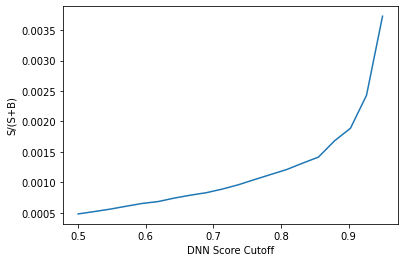

In [39]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
for value in test_sc:
    sc_vals.append(significance(value))
    
plt.plot(test_sc, sc_vals)
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.show()

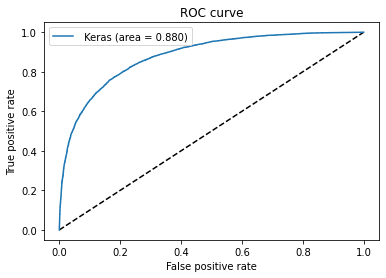

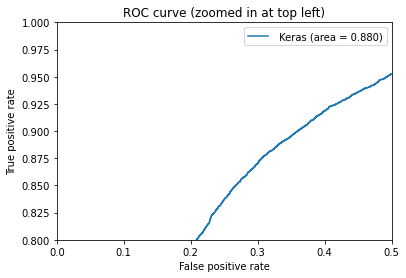

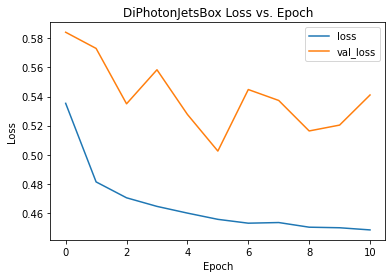

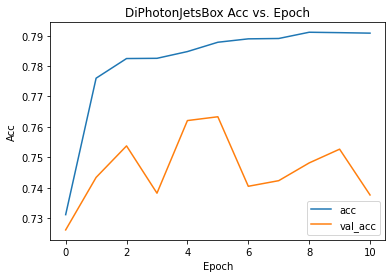

In [20]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=' Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/ROC_Plts/{names[i]}_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= ' Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
#plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/ROC_Plts/{names[i]}_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(names[i] + ' Loss vs. Epoch')
#plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/Epoch_Plts/{names[i]}_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title(names[i] + ' Acc vs. Epoch')
#plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/Epoch_Plts/{names[i]}_acc_epoch.png', format='png')
plt.show()

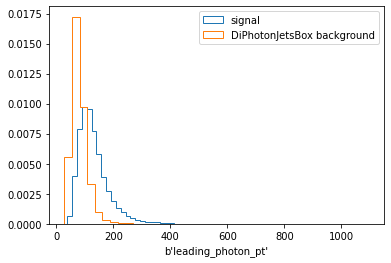

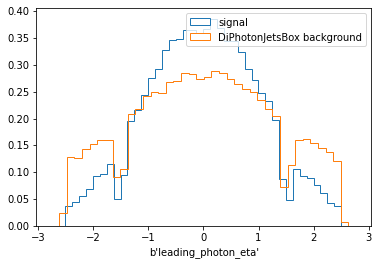

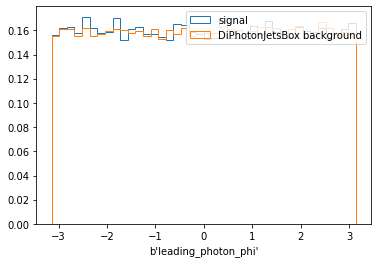

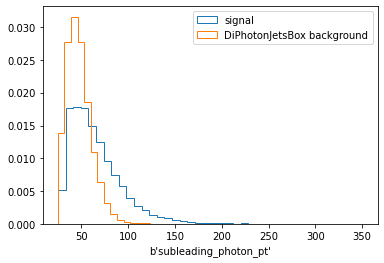

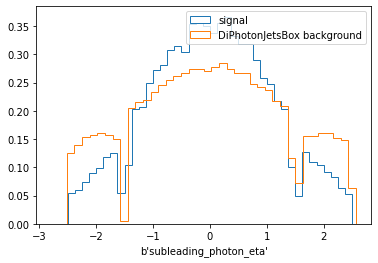

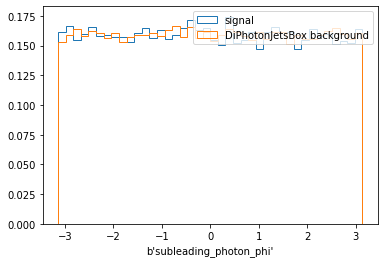

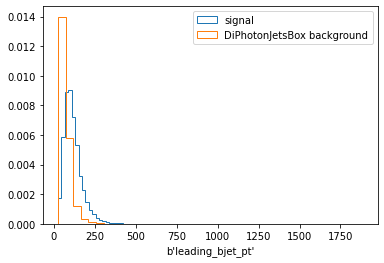

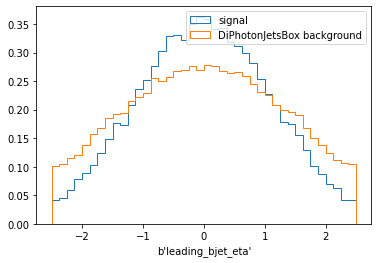

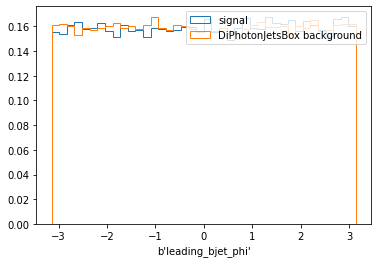

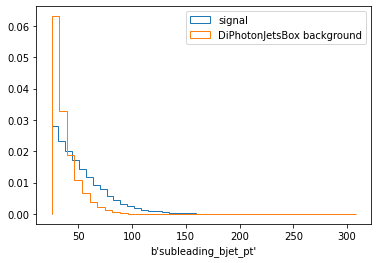

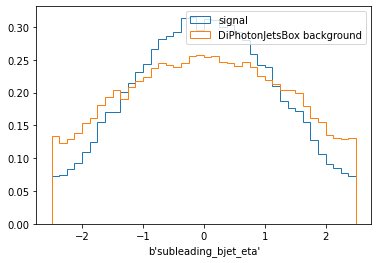

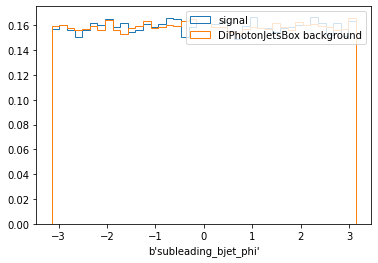

In [21]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= names[i] + ' background')
    plt.xlabel(hlf)
    #plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/BackgroundVsSignal_Plts/{names[i]}_{hlf}')
    plt.legend(loc='best')

# 